In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import seaborn as sns

In [2]:
cars_file = 'https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv'
cars = pd.read_csv(cars_file)
cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


<Axes: xlabel='wt', ylabel='mpg'>

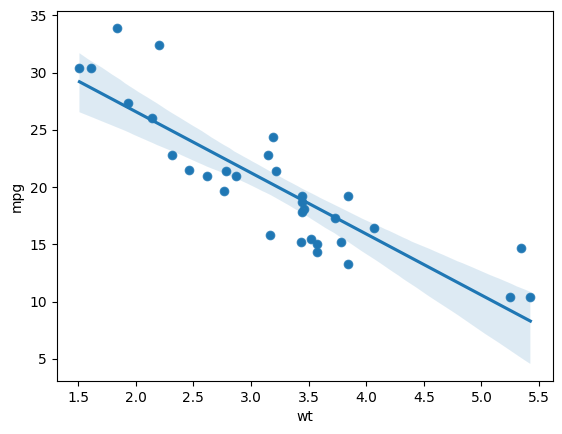

In [3]:
sns.scatterplot(x='wt', y='mpg', data=cars)
sns.regplot(x='wt', y='mpg', data=cars)

In [4]:
X_list = cars.wt.values
X_np = np.array(X_list, dtype=np.float32).reshape(-1,1)
y_list = cars.mpg.values
y_np = np.array(y_list, dtype=np.float32).reshape(-1,1)
X = torch.from_numpy(X_np)
y_true = torch.from_numpy(y_np)

In [5]:
class LinearRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_loader = DataLoader(dataset = LinearRegressionDataset(X_np, y_np), batch_size=2)

In [6]:
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

input_dim = 1
output_dim = 1
model = LinearRegressionTorch(input_size=input_dim, output_size=output_dim)
model.train()

LinearRegressionTorch(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [7]:
loss_fun = nn.MSELoss()

In [8]:
learning_rate = 0.02

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
losses = []
slope, bias = [], []
number_epochs = 1000
for epoch in range(number_epochs):
    for j, (X, y) in enumerate(train_loader):
        # optimization
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X)

        # compute loss
        loss = loss_fun(y_pred, y)
        losses.append(loss.item())

        # backprop
        loss.backward()

        # update weights
        optimizer.step()
    
    # get parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            if name == 'linear.weight':
                slope.append(param.data.numpy()[0][0])
            if name == 'linear.bias':
                bias.append(param.data.numpy()[0])


    # store loss
    losses.append(float(loss.data))
    # print loss
    if (epoch % 100 == 0):
        print(f"Epoch {epoch}, Loss: {loss.data}")

Epoch 0, Loss: 36.14952850341797
Epoch 100, Loss: 1.5697871446609497
Epoch 200, Loss: 1.4115588665008545
Epoch 300, Loss: 1.4094330072402954
Epoch 400, Loss: 1.409427285194397
Epoch 500, Loss: 1.409427285194397
Epoch 600, Loss: 1.409427285194397
Epoch 700, Loss: 1.409427285194397
Epoch 800, Loss: 1.409427285194397
Epoch 900, Loss: 1.409427285194397


<Axes: >

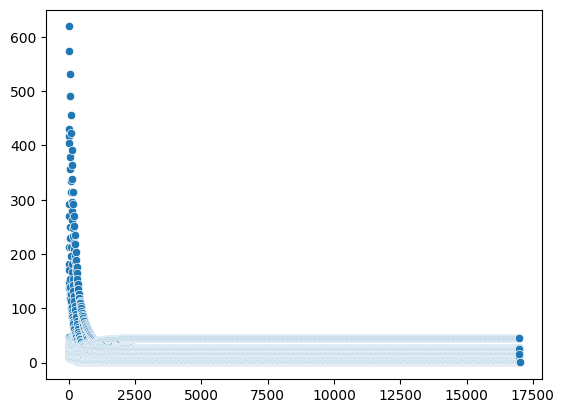

In [11]:
sns.scatterplot(x=range(len(losses)), y=losses)

<Axes: >

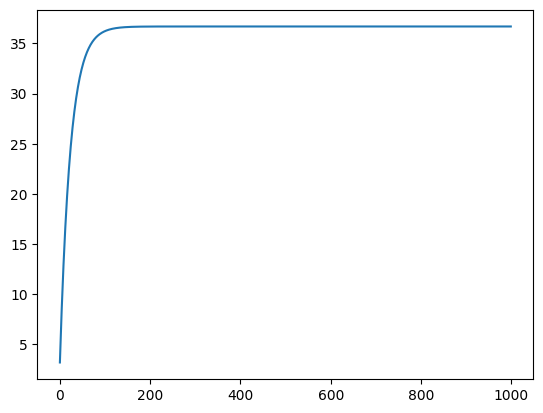

In [12]:
sns.lineplot(x=range(number_epochs), y=bias)

<Axes: >

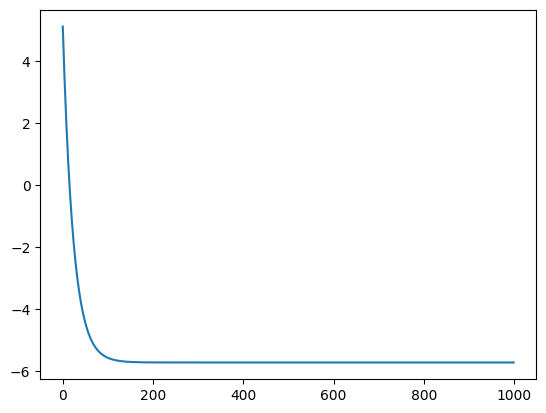

In [13]:
sns.lineplot(x=range(number_epochs), y=slope)

<Axes: >

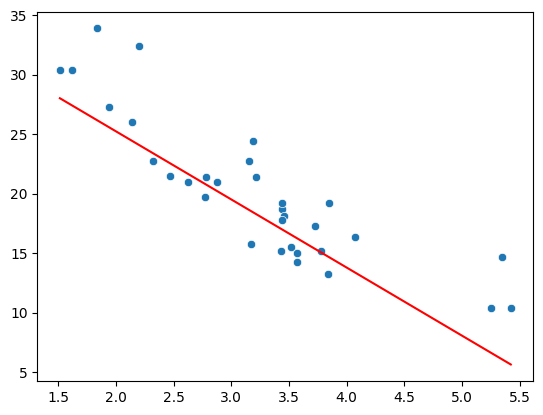

In [14]:
model.eval()
y_pred = [i[0] for i in model(torch.from_numpy(X_np)).data.numpy()]
y = [i[0] for i in y_true.data.numpy()]
sns.scatterplot(x=X_list, y=y)
sns.lineplot(x=X_list, y=y_pred, color='red')

#### Saving and loading the model

In [15]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[-5.7225]])),
             ('linear.bias', tensor([36.6935]))])

In [16]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [17]:
model = LinearRegressionTorch(input_size=input_dim, output_size=output_dim)

In [18]:
model.load_state_dict(torch.load('model_state_dict.pth'))
model.state_dict()

/var/tmp/ipykernel_423576/3867646662.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state_dict.pth'))


OrderedDict([('linear.weight', tensor([[-5.7225]])),
             ('linear.bias', tensor([36.6935]))])